# Описание проекта. Постановка задачи.

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 

**Задача.** Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».


## Общая информация

Описание данных
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Путь к файлу: /datasets/games.csv.


In [1]:
import pandas as pd   # Импортируем необходимые библиотеки
import numpy as np     
import matplotlib.pyplot as plt
from scipy import stats as st

import warnings       # отключили предупреждения          
warnings.filterwarnings('ignore')                   

actual_year = 2017    # Зададим текущий актуальный год, на который проводим анализ

In [2]:
data = pd.read_csv('games.csv')    # считываем базу

data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Как видим из информации по датафрейму, 6 из 11 столбцов имеют пропуски, в том числе две строки не содержат название игры, в двух пропущен жанр, не везде указан год релиза, не везде есть оценки критиков и пользователей или рейтинг от организации ESRB.

Еще одна задача предобработки данных - изменить имена столбцов согласно правилу хорошего стиля (заменить на нижний регистр).

## Подготовка данных

Заменим названия столбцов (приведем к нижнему регистру).

In [3]:
data.columns = data.columns.str.lower()         # Переименовываем, используя ф-ции замены на строчные
print(data.columns)                             # Проверяем

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


Сначала разберемся с пропусками NaN. Посмотрим, что представляют строки с пропущенным названием или жанром.

In [4]:
display(
    data[
        (data['name'].isna()) | (data['genre'].isna())      # Применили isna() для среза
    ]
)                     

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Видим, что жанр пропущен там же, где и название. Так как строк всего две, удалим их.

In [5]:
data = data.dropna(subset=['name'])                # Удалили строки с NaN в 'name'

Так как число строк без года релиза составляет порядка 1.5% от общего числа строк датафрейма, разумнее не учитывать их вообще, поскольку основное, на что мы можем опираемся при данном исследовании, это год выпуска - нас интересует в основном год, предшествующий запланированной на следующий год кампании.  Поэтому удалим строки с пропусками года релиза.

In [6]:
number_nan = (data['year_of_release'].
                isna().
                sum()                     # Нашли сумму пропусков в строке года
             )
percent_nan = number_nan / data.shape[0]  # Нашли отрношение пропусков к общему числу строк

(data['year_of_release'].
    dropna().                             #  Удалили NaN в 'year_of_release',
    astype(dtype='int', copy=True).       #  изменили тип
    reset_index(drop=True)                #  и обновили индексацию.
)
 
print('Было удалено строк:', number_nan)
print(f'Это составляет: {percent_nan:.2%}')

Было удалено строк: 269
Это составляет: 1.61%


Мы можем преобразовать данные в нужные типы: год релиза 'year_of_release' - в int, рейтинги 'critic_score' и 'user_score' - в int (предварительно умножив 'user_score'на 10, тогда он будет аналогично 'critic_score' принимать целочисленные значения от 0 до 100). Нужно ли нам это, и стоит ли убрать все пропуски из соответствующих столбцов?

Посмотрим, что может помешать переводу в целочисленные значения столбцов с рейтингом. Выведем уникальные значения.

In [7]:
print(data['critic_score'].unique())
print(data['user_score'].unique())

[76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65. 54.
 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 35. 41. 36.
 28. 31. 27. 26. 19. 23. 24. 21. 17. 22. 13.]
['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


Если приводить к целочисленным значениям столбцы 'critic_score', 'user_score', то предварительно нужно будет заменить NaN (и 'tbd' в 'user_score') на какие-либо числовые значения, но любое искусственно добавленное значение рейтинга повлияет на итоговые выводы, поэтому замена на 0 или на среднее/медианное и т.п. значение не подходит. Оставим NaN как есть, а тип менять на int не будем.

Что касается значения 'tbd' в 'user_score', то это To Be Determined, то есть "будет определено". Возможно, пользовательский рейтинг еще не определен или не может быть посчитан при нулевом или очень низком уровне продажи. Проверим, выведем на экран несколько таких случайных строк.

In [8]:
display(data
        [data['user_score']=='tbd'].
            sample(10)
       ) 

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
10913,Championship Foosball,Wii,2008.0,Sports,0.09,0.00,0.0,0.01,NaN,tbd,E
10756,Petz Hamsterz Superstarz,DS,2009.0,Simulation,0.09,0.00,0.0,0.01,NaN,tbd,E
11932,Rock Band Country Track Pack 2,PS3,2011.0,Misc,0.07,0.00,0.0,0.01,NaN,tbd,E10+
2512,Karaoke Revolution Glee,Wii,2010.0,Misc,0.51,0.24,0.0,0.07,NaN,tbd,T
9235,4x4 EVO 2,GC,2002.0,Racing,0.11,0.03,0.0,0.00,56.0,tbd,E
15566,Army Rescue,Wii,2009.0,Shooter,0.02,0.00,0.0,0.00,NaN,tbd,E
10544,PictoImage,DS,2007.0,Puzzle,0.09,0.00,0.0,0.01,61.0,tbd,E
3567,Harry Potter Collection,PS2,2006.0,Misc,0.28,0.21,0.0,0.07,NaN,tbd,E10+
8560,Family Game Night 4: The Game Show,Wii,2011.0,Misc,0.12,0.03,0.0,0.01,NaN,tbd,E
7146,Ben 10 Ultimate Alien: Cosmic Destruction,PS2,2010.0,Platform,0.13,0.06,0.0,0.04,NaN,tbd,E10+


По-видимому, мы были правы, продажи не велики, очень часто tbd сочетается с NaN в оценке критиков. Заменим 'tbd' на 'NaN'. 
Затем столбец приведем к численному типу. 

In [9]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

data['user_score'] = data['user_score'].astype('float') 

Осталось посмотреть, что представляет из себя последний столбец 'rating'.

In [10]:
print(data.rating.unique())

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


- «EC» («Early childhood») — «Для детей младшего возраста».
- «E» («Everyone») — «Для всех».
- «E10+» («Everyone 10 and older») — «Для всех старше 10 лет».
- «T» («Teen») — «Подросткам 13—19 лет».
- «M» («Mature») — «От 17 лет».
- «AO» («Adults Only 18+») — «Только для взрослых».
- «RP» ( «Rating Pending»») — «Рейтинг ожидается».
- «K-A» - «Для детей» (в 1998 году был переименован в Е – для всех возрастов).

Как видим, здесь всё в порядке, все соответствует расшифровкам ESRB либо пропущено.

И посчитаем теперь суммарные продажи во всех регионах в отдельный столбец 'all_sales'.

In [11]:
data['all_sales'] = data[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

Осталось проверить наличие дубликатов.

In [12]:
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


## Исследовательский анализ данных

### Сколько игр выпускалось в разные годы? 

Построим столбчатую диаграмму.

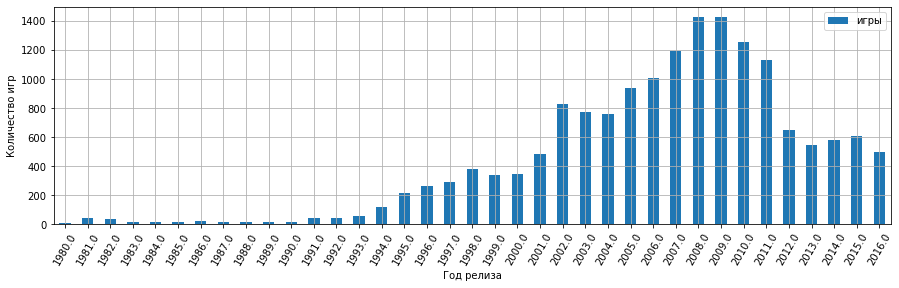

In [13]:
data.pivot_table(index='year_of_release', 
                 values='name', 
                 aggfunc='count'
                ).plot(
                        kind='bar', 
                        figsize=(15, 4), 
                        grid=True, 
                        rot=60
                      )           

plt.legend(['игры'])
plt.xlabel('Год релиза') # Подписали ось X
plt.ylabel('Количество игр') # Подписали ось Y
plt.show()

Больше всего выпускалось игр в период с 2006 по 2011 год (более тысячи в год). Самыми активными были 2008 и 2009 годы, более 1400 игр за год. С 2012 года количество выпущенных игр упало до 500-600 в год.

Нас интересует не весь период, для целей анализа важны только последние годы. 

### Как менялись продажи по платформам?

Выберем платформы с наибольшими суммарными продажами за весь период и построим распределение по годам. Для этого построим гистограмму. 

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC'], dtype='object', name='platform')


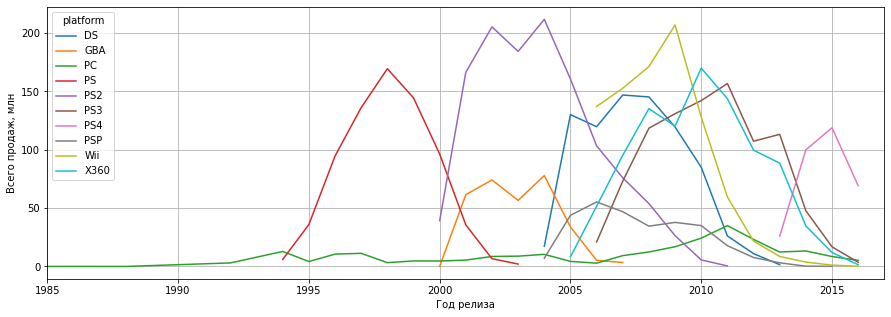

In [14]:
platform_sales_10 = (data.
                        groupby('platform').
                        agg({'all_sales': 'sum'}). # Группируем по суммам продаж
                        sort_values(by='all_sales', ascending=False).   # сортируем по убыванию продаж,
                        head(10).                  # берем верхние 10 строк и
                        index                      # получаем в переменной список значений столбца 'platform'
                    )

print(platform_sales_10)  # вывели списком - для себя

(data.
    query('platform in @ platform_sales_10').               # для среза по условию "platform in @ platform_sales"
    pivot_table(                                            # строим сводные таблицы
        index='year_of_release', 
        columns='platform', 
        values='all_sales', 
        aggfunc='sum'
               ).
    plot(figsize=(15, 5), xlim=(1985, 2017), grid=True)     # и для них строим гистограммы
)  

plt.xlabel('Год релиза') # Подписали ось X
plt.ylabel('Всего продаж, млн') # Подписали ось Y
plt.show()

Из графиков видно, что примерно за 7-10 лет практически любая платформа себя изживает и исчезает с рынка игр, но за это время 4-5 лет держится на пике популярности. И только платформа PC тридцать лет сохраняет свои позиции. 

И если в 2006 - 2007 годах среди популярных можно было встретить одновременно 8 из Топ-10 платформ, то в 2016 году их число сократилось до 5, причем 4 из них имеют весьма низкие продажи. Более-менее высокий уровень продаж остался у PS4, но и он падает по сравнению с 2015 г. 

### Найдем актуальный период
Для того, чтобы построить прогноз на 2017 год, необходимо проанализировать актуальный период для каждой игры. Найдем его так:  выбираем минимальный порог продаж (например, 1 млн). Для каждой платформы ищем число лет, когда суммарные продажи превышают этот порог. Это будет средним временем жизни платформы. 

Мне кажется разумным взять половину от среднего времени жизни платформы и принять это время за актуальный период, так как из времени жизни платформы половину времени продажи растут, половину падают. Нам не интересны "умирающие" к концу периода платформы. 



Рассматриваем топ-10, полученный выше, так как наша задача - анализировать самые коммерчески выгодные игры. И из расчетов уберем "PC", как явно выбивающееся из общей тенденции значение в 30 лет. Ничего личного не имею против ПК, но значение в 30 лет очень похоже на выброс и увеличивает среднее время жизни платформы на полтора года, а принятый за половину этого времени актуальный период - на год. Плюс объемы продаж даже в лучшие для PC времена не превышали 30-35 млн копий в год (мы же не принимаем в расчет пиратские копии), что по сравнению с "быстроживущими", но более прибыльными прочими платформами совсем не много. Можно считать PC феноменом и "почетным пиратом-долгожителем" и считаться с ним, тем более, что позиций персональные компьютеры и дальше сдавать не собираются. Но при расчете среднего срока жизни платформы для всех остальных коммерческих платформ это значение является лишним, то есть выбросом.
    
Ниже построим boxplot для PC, на нем видно, что по крайней мере до 2000 г. продажи с количеством копий более 1 млн экз., раз уж мы взяли именно такой критерий - это выбросы.


<AxesSubplot:title={'center':'year_of_release'}, xlabel='platform'>

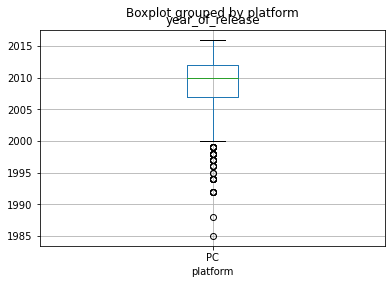

In [15]:
data[data['platform'] == 'PC'].boxplot(by='platform', column='year_of_release')

In [16]:
act_period = (data.
                 groupby(['platform','year_of_release']).         # новый датафрейм - группируем по платформе и году релиза
                 agg({'all_sales': 'sum'}).                       # сумма всех продаж для конкретной платформы в один год
                 query('(platform in @ platform_sales_10) and (platform != "PC") and (all_sales > 1)').   #  срез по условиям   
                 reset_index()                                    # обновляем индекс
             )

act_period = (act_period.groupby('platform').                # группировкой расчитаем период жизни каждой платформы из топ-10
                 agg({'year_of_release': 'count'})           # считаем количество элементов в 'year_of_release'
             ) 

time_mean_period = act_period['year_of_release'].mean()      # считаем среднее значение - находим средний актуальный период

print(f'Среднее время жизни платформы: {time_mean_period:.1f}')

actual_period = np.ceil(time_mean_period/2)                  # округлили в большую сторону

print(f'Актуальный период: {actual_period:.0f}')             # значение актуального периода

Среднее время жизни платформы: 9.4
Актуальный период: 5


 Теперь при анализе будем учитывать данные не более, чем за 5 предыдущих лет.

### Найдем лидирующие платформы

Посмотрим, какие платформы лидируют по продажам, какие растут или падают. Выберем несколько потенциально прибыльных платформ в актуальном периоде. 
В нашем конкретном случае 2017 минус 9 лет, получим период с 2012 по 2016 гг, а вообще создадим новую переменную **begin_year** - начальный год, с которого проводится анализ.

In [17]:
begin_year = actual_year - actual_period  #  начальный год, с которого проводится анализ
                                          #  Посчитано как разность текущего года и актуального периода

Index(['PS4', 'PS3', 'X360', '3DS', 'XOne'], dtype='object', name='platform')


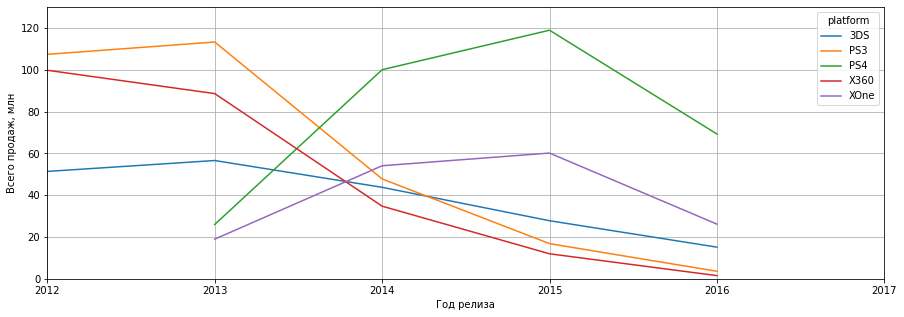

In [18]:
platform_top_actual = (
                      data[data['year_of_release'] >=begin_year].  # срез - только актуальный период
                          groupby('platform').agg({'all_sales': 'sum'}).
                          sort_values(by='all_sales', ascending=False).
                          head(5).  # top-5
                          index
                      ) 
print(platform_top_actual) # вывели для себя

(data.query('platform in @ platform_top_actual').
      pivot_table(
          index='year_of_release', 
          columns='platform', 
          values='all_sales', 
          aggfunc='sum'
      ).
      plot(figsize=(15, 5), 
           grid=True, 
           xlim=(2012, 2017), 
           ylim=(0, 130)
          )
) 

plt.xlabel('Год релиза') # Подписали ось X
plt.ylabel('Всего продаж, млн') # Подписали ось Y
plt.show()

В актуальном периоде мы получили иные значения топ-платформ, чем когда рассматривали топ продаж по всему периоду. Появились 3DS и XOne. 
По графикам видим, что продажи по всем топ-5 падают в 2016 г. по сравнению с 2015 годом. Ни у одной платформы роста мы не наблюдаем. Лидер с явным отрывом - это PS4.

Построим еще график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

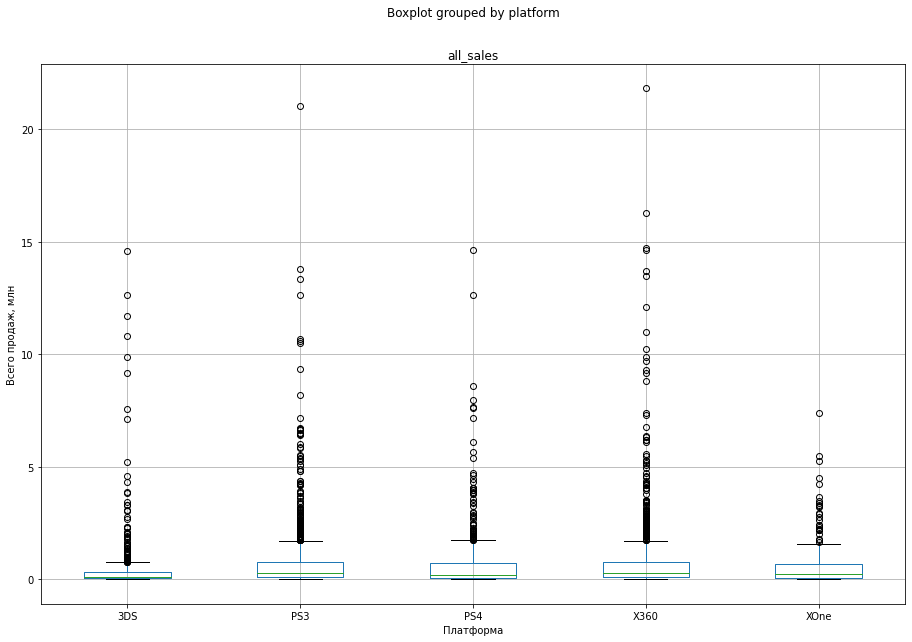

In [19]:

(data.query('platform in @ platform_top_actual').
     boxplot(by='platform', 
             column='all_sales', 
             figsize=(15, 10)
            )
)  

plt.xlabel('Платформа') # Подписали ось X
plt.ylabel('Всего продаж, млн') # Подписали ось Y
plt.show()

In [20]:
print(data[data['platform'] == 'X360']['all_sales'].
          describe()                                # В помощь при описании вызвали метод describe()
      )                                             # Наиболее "интересная" платформа -'X360' с максимальной продажей

count    1262.000000
mean        0.769746
std         1.615674
min         0.010000
25%         0.110000
50%         0.280000
75%         0.757500
max        21.820000
Name: all_sales, dtype: float64


 Данные "графики с усами" показывают, что медианное значение у четырех платформ ('PS4', 'PS3', 'X360', 'XOne') примерно на одном уровне и не более 0.28 миллиона, межквартильный размах примерно одинаков, третий квартиль не более 1 млн, а у '3DS' еще меньше. Это означает, что большинство проданных игр не перешагивает порог продаж в 1 млн экземпляров, а в среднем находится на уровне 250 тыс. проданных копий.
    
При этом "выбросы", то есть игры с несравнимо большим количеством продаж, могут иметь и пару десятков миллионов проданных копий - почти в 80 раз больше, чем среднестатистическая на той же платформе! Например, одна из игр на платформе X360 имеет 21,82 млн продаж. А также около десятка игр для X360 имели продажи 10 млн и более. Но именно они смещают среднее значение проданных копий в большую сторону по сравнению с медианным в 2,5 раза.
    
В плане таких популярных игр PS3 и X360 выглядят более успешными, чем PS4 и 3DS, а XOne находится в аутсайдерах.

### Диаграммы рассеяния и корреляция
Посмотрим, как влияют на продажи внутри одной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния в целом для топ-5 платформ **за весь период времени** и посчитаем корреляцию между отзывами и продажами.

Для рейтинга критиков наблюдается некоторая положительная корреляция между оценками и продажами. А вот с оценками пользователей всё не так очевидно.

Найдем численное значение коэффициента корреляции Пирсона.

In [21]:
corr_sales_critic_score = (data.
                               query('platform in @ platform_top_actual')['all_sales'].
                               corr(data.
                                    query('platform in @ platform_top_actual')['critic_score']
                                   )
                          )

print(f'Коэффициент корреляции между оценками критиков и продажами: {corr_sales_critic_score:.2f}')


corr_sales_user_score = (data.
                             query('platform in @ platform_top_actual')['all_sales'].
                             corr(data.
                                  query('platform in @ platform_top_actual')['user_score']
                                 )
                        )

print(f'Коэффициент корреляции между оценками пользователей и продажами: {corr_sales_user_score:.2f}')


Коэффициент корреляции между оценками критиков и продажами: 0.40
Коэффициент корреляции между оценками пользователей и продажами: 0.10


Как видим, объемы продаж и высокие оценки критиков имеют достаточно тесную линейную взаимосвязь, в то время как для оценок пользователей такая связь намного слабее.

Возможно, ситуация окажется иной, если рассматривать платформы по отдельности и толькло в актуальном периоде. Для этого построим диаграммы рассеяния для найденных ранее топ-5 платформ (platform_top_actual) в **актуальном периоде**.

Коэффициент корреляции между оценками критиков и продажами PS4: 0.41


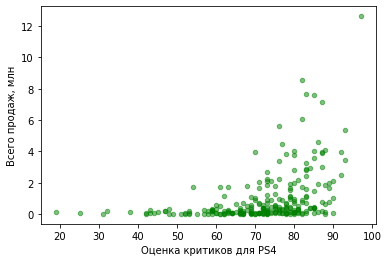

Коэффициент корреляции между оценками критиков и продажами PS3: 0.33


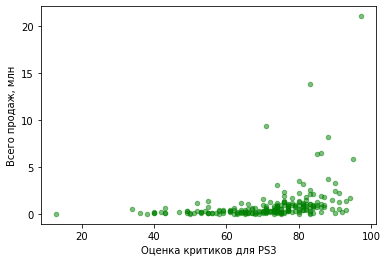

Коэффициент корреляции между оценками критиков и продажами X360: 0.36


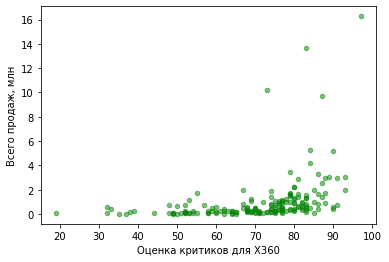

Коэффициент корреляции между оценками критиков и продажами 3DS: 0.32


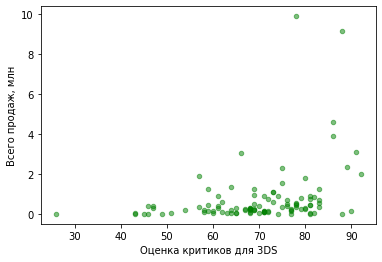

Коэффициент корреляции между оценками критиков и продажами XOne: 0.42


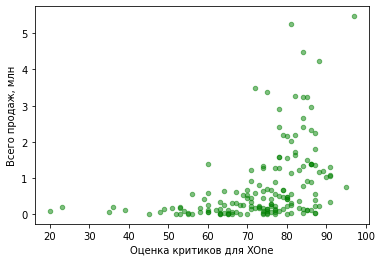

In [22]:
for x in platform_top_actual:
    (data.
     query('platform == @ x and year_of_release>= @ begin_year').
     plot(y='all_sales', 
          x='critic_score', 
          kind='scatter', 
          alpha=0.5, 
          color='green')
    )
    plt.xlabel('Оценка критиков для ' + x) #  ось X
    plt.ylabel('Всего продаж, млн')        #  ось Y
    
    corr_sales_critic_score = (data.
                               query('platform == @ x and year_of_release>=@ begin_year')['all_sales'].
                               corr(data.
                                    query('platform == @ x and year_of_release>=@ begin_year')['critic_score']
                                   )
                              )
    
    print(f'Коэффициент корреляции между оценками критиков и продажами {x}: {corr_sales_critic_score:.2f}')
    plt.show()

В среднем наблюдаем ту же картину, что и для корреляции в целом по топ-5, чуть слабее у платформы 3DS, чуть сильнее у XOne.

Посмотрим на пользовательские оценки.

Коэффициент корреляции между оценками пользователей и продажами PS4: -0.03


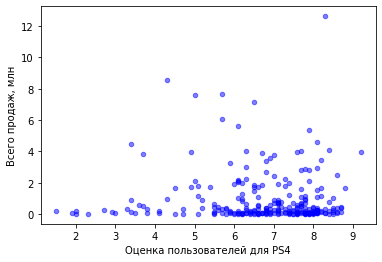

Коэффициент корреляции между оценками пользователей и продажами PS3: -0.01


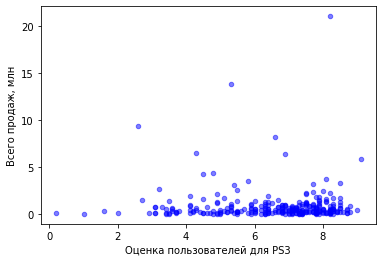

Коэффициент корреляции между оценками пользователей и продажами X360: 0.01


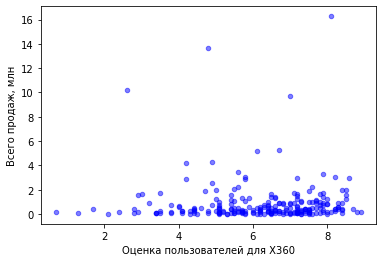

Коэффициент корреляции между оценками пользователей и продажами 3DS: 0.20


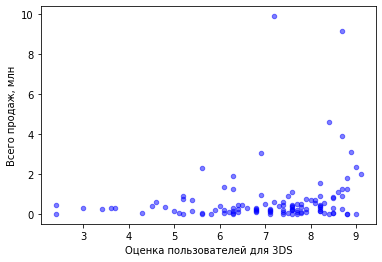

Коэффициент корреляции между оценками пользователей и продажами XOne: -0.07


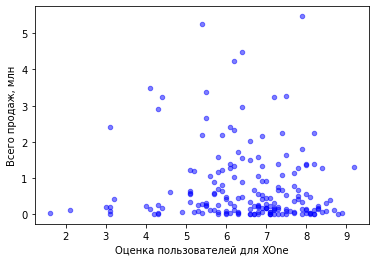

In [23]:
for x in platform_top_actual:
    (data.
     query('platform == @ x and year_of_release>= @ begin_year').
     plot(y='all_sales', 
          x='user_score', 
          kind='scatter', 
          alpha=0.5, 
          color='blue'
         )
    )
    plt.xlabel('Оценка пользователей для ' + x)   # ось X
    plt.ylabel('Всего продаж, млн')               # ось Y
    
    corr_sales_user_score = (data.
                             query('platform == @ x and year_of_release>= @ begin_year')['all_sales'].
                             corr(data.
                                  query('platform == @ x and year_of_release>= @ begin_year')['user_score']
                                 )
                            )
    print(f'Коэффициент корреляции между оценками пользователей и продажами {x}: {corr_sales_user_score:.2f}')
    plt.show()

А вот здесь картина намного разнообразнее, коэффициент корреляции Пирсона даже где-то отрицательный, но всё равно очень близкий к нулю, даже не 0,1, как было получено для всего периода по всем платформам. И только у 3DS он 0,2, но и это не высокий показатель.
Так что опираться при прогнозировании популярности и продаж на пользовательскую оценку не стоит. Это чисто субъективное мнение, причем, очевидно, только достаточно взрослой части населения, поскольку дети, для которых в том числе пишутся игры, особенно маленькие, вряд ли будут оставлять отзывы на сайтах.

### Анализ по жанрам

Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Как видно из графиков, продаваемость жанров в актуальный период, по большей части, остается достаточно постоянной, всё это время лидируют четыре жанра: Action, Shooter, Sports, Role-Playing. Популярность первого (Action) в актуальном периоде упала сильнее, чем у остальных жанров, и даже стала уступать Shooter в 2016 г.

Остальные жанры уступают топ-4 по числу продаж в несколько раз.

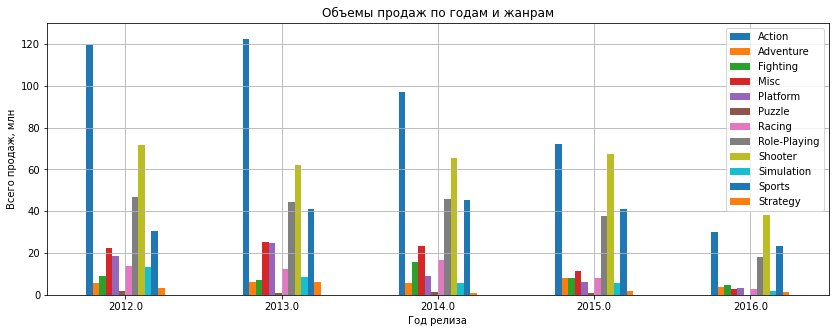

In [24]:

genre_actual = data['genre'].unique()    # Создали список уникальных значений жанров.


(data.
 query('genre in @ genre_actual and year_of_release>= @ begin_year').
 pivot_table(index='year_of_release', 
             columns='genre', 
             values='all_sales', 
             aggfunc='sum'
            ).
 plot(kind='bar', 
      figsize=(14, 5), 
      grid=True, 
      ylim=(0, 130), 
      title='Объемы продаж по годам и жанрам', 
      rot=0
     )
) 

plt.xlabel('Год релиза')           #  ось X
plt.ylabel('Всего продаж, млн')    #  ось Y

plt.legend(bbox_to_anchor=(1, 1))  #  Сдвинули легенду 
plt.show()


Как видно из графиков, продаваемость жанров в актуальный период, по большей части, остается достаточно постоянной, всё это время лидируют четыре жанра: Action, Shooter, Sports, Role-Playing. Популярность первого (Action) в актуальном периоде упала сильнее, чем у остальных жанров, и даже стала уступать Shooter в 2016 г. Остальные жанры уступают топ-4 по числу продаж в несколько раз.


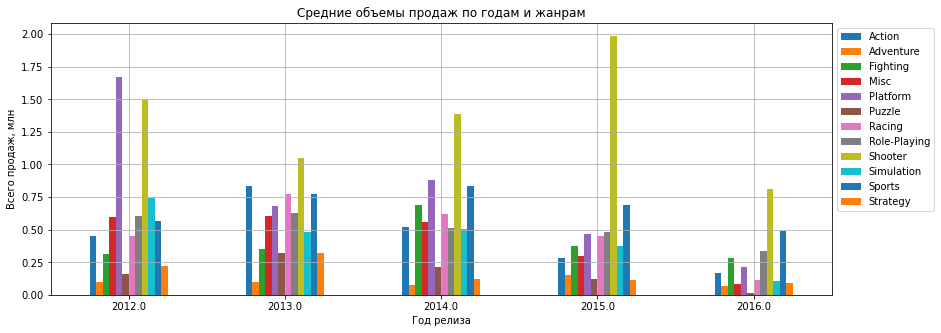

In [25]:
(data.
 query('genre in @ genre_actual and year_of_release>= @ begin_year').
 pivot_table(index='year_of_release', 
             columns='genre', 
             values='all_sales', 
             aggfunc='mean'
            ).
 plot(kind='bar', 
      figsize=(14, 5), 
      grid=True, 
      title='Средние объемы продаж по годам и жанрам', 
      rot=0
     )
) 

plt.xlabel('Год релиза')           #  ось X
plt.ylabel('Всего продаж, млн')    #  ось Y

plt.legend(bbox_to_anchor=(1, 1))  # Сдвинули легенду
plt.show()


Если посмотреть не общий объем продаж, а медианные (или средние значения - картина практически не меняется), то есть продаваемость каждой конкретной игры в среднем, то да, возможно, что Action делает большие объемы продаж только за счет большего количества игр или большого количества бестселлеров, либо и то, и то вместе. 
По средним объемам продаж каждой игры абсолютное лидерство держит Shooter, в последний год за стрелялками идет Sports и Role-Playing. А вот популярность одной средне взятой игры Action в актуальном периоде падает год за годом.



## Портрет пользователя каждого региона
Определим характерные для пользователя каждого региона (NA, EU, JP) закономерности.


### Самые популярные платформы (топ-5). 
Определим для пользователей каждого региона (NA, EU, JP) самые популярные платформы. 

Сначала рассмотрим продажи и топ-5 в Северной Америке (NA), затем в Европе и Японии. В каждом регионе ожидается свой набор топ-5 платформ.


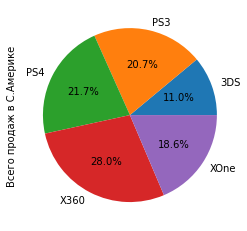

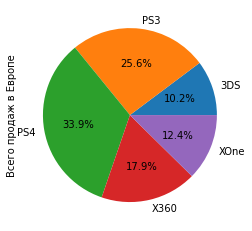

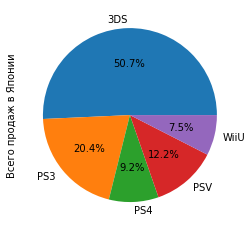

In [26]:
platform_top_na = (                                    # NA - Северная Америка
                      data[data['year_of_release'] >= begin_year].       # срез - только актуальный период
                          groupby('platform').
                          agg({'na_sales': 'sum'}).
                          sort_values(by='na_sales', ascending=False).
                          head(5).                                       # top-5
                          index
                      ) 

df_na = (data.
         query('platform in @ platform_top_na and year_of_release >= @ begin_year'). # сводная таблица сумм продаж по годам и платформам
         pivot_table(index='platform', 
                     values='na_sales', 
                     aggfunc='sum'
                    )
         ) 
# Строим круговую диаграмму по продажам для Америки.

df_na.plot(kind='pie',                  # Круговая диаграмма по столбцу sum
           y='na_sales', 
           legend="", 
           autopct='%1.1f%%'
          ) 
plt.ylabel('Всего продаж в С.Америке')  # Подписали 
plt.show()

#     Аналогично построим круговые диаграммы продаж для Европы и Японии (EU, JP).

platform_top_eu = (                # EU - Европа   - нашли топ-5
                      data[data['year_of_release'] >= begin_year].  # срез - только актуальный период
                      groupby('platform').
                      agg({'eu_sales': 'sum'}).
                      sort_values(by='eu_sales', ascending=False).
                      head(5).    # top-5
                      index  
                  ) 

df_eu = (data.
         query('platform in @ platform_top_eu and year_of_release >= @ begin_year'). # сводная таблица сумм продаж по годам и платформам
         pivot_table(index='platform', 
                     values='eu_sales', 
                     aggfunc='sum'
                    )
        ) 

df_eu.plot(kind='pie',              # Круговая диаграмма по столбцу sum
           y='eu_sales', 
           legend="", 
           autopct='%1.1f%%'
          ) 
plt.ylabel('Всего продаж в Европе') # Подписали 
plt.show()


platform_top_jp = (        # JP - Япония   - нашли топ-5
                      data[data['year_of_release'] >= begin_year].  
                      groupby('platform').
                      agg({'jp_sales': 'sum'}).
                      sort_values(by='jp_sales', ascending=False).
                      head(5). 
                      index  
                   )

df_jp = (data.
         query('platform in @ platform_top_jp and year_of_release >= @ begin_year').     
         pivot_table(index='platform',  
                     values='jp_sales', 
                     aggfunc='sum')
        ) 

df_jp.plot(kind='pie', 
           y='jp_sales', 
           legend="", 
           autopct='%1.1f%%'
          ) 

plt.ylabel('Всего продаж в Японии') 
plt.show()

В Европе и Америке популярные жанры одинаковые, пропорционально тоже примерно одна картина (только в Америке больше продано игр на Х360, а в Европе на PS4.

Зато в Японии и топ-5 отличается - есть WiiU и PSV, но нет XOne и X360. И существенно отличаются пропорции, например, доля 3DS в Европе и Америке - около 1/8 или 1/9, а в Японии - больше половины. Похоже, что японцы больше любят портативные консоли и родной рынок.

### Самые популярные жанры (топ-5). 
Посмотрим, есть ли разница в популярных жанрах. Поступим аналогично, построив круговые диаграммы.

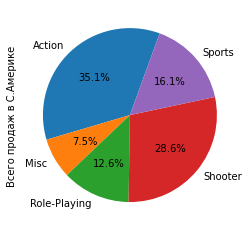

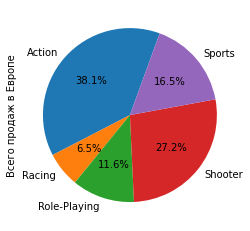

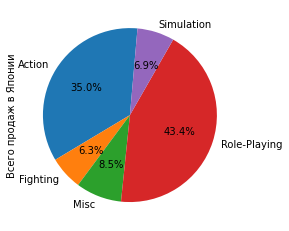

In [27]:
# NA - Северная Америка

genre_top_na = (data[data['year_of_release'] >= begin_year].  # срез - только актуальный период
                groupby('genre').
                agg({'na_sales': 'sum'}).
                sort_values(by='na_sales', ascending=False).
                head(5).  # top-5 
                index       
               )

df_genre_na = (data.query('genre in @ genre_top_na and year_of_release >= @ begin_year'). # сводная таблица 
               pivot_table(index='genre', 
                           values='na_sales', 
                           aggfunc='sum'
                          )
              ) 

(df_genre_na.
    plot(kind='pie',     # Круговая диаграмма
         y='na_sales', 
         legend="", 
         startangle=70, 
         autopct='%1.1f%%'
        ) 
)
plt.ylabel('Всего продаж в С.Америке') 
plt.show()

#     Аналогично построим круговые диаграммы продаж для Европы и Японии (EU, JP).

# EU - Европа

genre_top_eu = (data[data['year_of_release'] >= begin_year].  # срез - только актуальный период
                groupby('genre').
                agg({'eu_sales': 'sum'}).
                sort_values(by='eu_sales', ascending=False).
                head(5).
                index     
               )

df_genre_eu = (data.
               query('genre in @ genre_top_eu and year_of_release >= @ begin_year'). # сводная таблица 
               pivot_table(index='genre', 
                           values='eu_sales', 
                           aggfunc='sum'
                          )
              )             
(df_genre_eu.
     plot(kind='pie',      # Круговая диаграмма
          y='eu_sales', 
          legend="", 
          startangle=70, 
          autopct='%1.1f%%'
         )  
)
plt.ylabel('Всего продаж в Европе') # Подписали 
plt.show()



# JP - Япония

genre_top_jp = (data[data['year_of_release'] >= begin_year].  # срез - только актуальный период
                groupby('genre').
                agg({'jp_sales': 'sum'}).
                sort_values(by='jp_sales', ascending=False).
                head(5).
                index      
               )
df_genre_jp = (data.query('genre in @ genre_top_jp and year_of_release >= @ begin_year'). # сводная таблица 
               pivot_table(index='genre', 
                           values='jp_sales', 
                           aggfunc='sum'
                          )  
              )     
(df_genre_jp.
     plot(kind='pie',    # Круговая диаграмма 
          y='jp_sales', 
          legend="", 
          startangle=85, 
          autopct='%1.1f%%') 
)
plt.ylabel('Всего продаж в Японии') 
plt.show()

И по жанрам Япония очень отличается от Европы и Америки, где картина, практически, идентична.

Похожего у Японии только жанр Action - даже доля на рынке почти такая же, как в NA и EU. Так же представлен жанр Role-Playing, но в Японии его доля более чем в три c половиной раза выше. И в Японии в топ-5 жанров входят Fighting, Misc, Simulation против европейско-американских Shooter, Racing, Sports.

Отличие Японии от других регионов может объясняться многими причинами, начиная от разработанных собственных платформ и игр до свойств национального характера. На эту тему есть несколько интересных статей в Интернете, пересказывать их нет смысла, но наглядно мы это увидели и сами.

Найдем долю проданных в Японии копий в сравнении с остальными, чтобы понять, насколько критичны отличия.

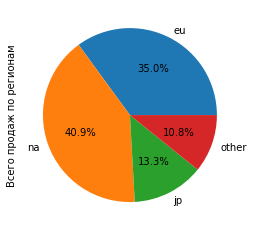

In [28]:
regions=['eu', 'na', 'jp', 'other'] # Задали регионы

pies = []  # Создали пустой список с суммами продаж

for reg in regions:  # в цикле добавляем в строку сумму продаж в актуальном периоде
    column = reg + '_sales'
    (pies.
     append(
         (data.
             query('year_of_release >= @ begin_year')[column]
         ).sum()
            )
    )

table_pies = pd.Series(pies) # Из полученного списка создаем Series

table_pies.index = regions  # Присваиваем индексам значения из regions


table_pies.plot(kind='pie', # Круговая диаграмма 
                y='pies', 
                legend="", 
                autopct='%1.1f%%'
               ) 
plt.ylabel('Всего продаж по регионам')
plt.show()

На круговой диаграмме видно, что доля продаж в Японии от общего числа анализируемых продаж составляет порядка 1/8. А продажи в Сев. Америке и Европе примерно одинаковы и составляют около 3/8.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе


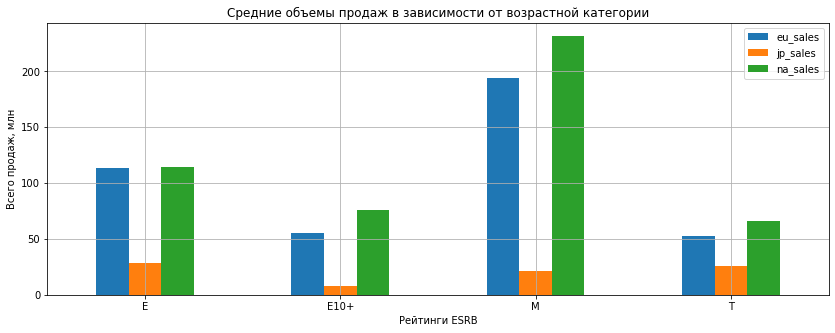

In [29]:
(
    data.
    query('year_of_release>= @ begin_year').
    pivot_table(index='rating', 
                values=['na_sales', 'eu_sales', 'jp_sales'], 
                aggfunc='sum'
               ).
    plot(kind='bar', 
         figsize=(14, 5), 
         grid=True, 
         title='Средние объемы продаж в зависимости от возрастной категории', 
         rot=0
        )
) 

plt.xlabel('Рейтинги ESRB')     #  ось X
plt.ylabel('Всего продаж, млн') #  ось Y
plt.show()

 Достаточно неожиданно в актуальном периоде осталось всего 4 категории, пропали «EC» и «AO». «K-A» переименован с 1998 г в «E». Видимо, «EC» («Для детей младшего возраста») с какого-то года не стали выделять отдельно и включили в «E», а «AO» («Только для взрослых») попало в «M» («Mature»).
    
Больше всего в Сев. Америке и Европе продается игр категории «M» («Mature» — «От 17 лет»), практически столько же, сколько детских и подростковых: «E» («Everyone») — «Для всех», «E10+» («Everyone 10 and older») — «Для всех старше 10 лет», «T» («Teen») — «Подросткам 13—19 лет».
    
При этом Япония, вроде бы, и здесь отличилась, показав низкие продажи по всем категориям ESRB, но мы помним, что объемы продаж в ней составляют около трети от продаж в Америке или Европе, значит, дело в чем-то еще. Проверим, все ли игры, продаваемые в Японии, имеют рейтинг ESRB, и какова доля игр без рейтинга.


In [30]:
print('Количество пропущенных значений рейтинга ESRB по Японии:', 
      (data.
       query('(year_of_release >= @ begin_year) and (jp_sales !=0)')['rating'].   # Продажи в 'jp_sales' не равны 0
       isna().        # нашли пропуски 
       sum()          # суммой посчитали их количество
      )    
     )

print('Количество имеющихся значений рейтинга ESRB по Японии:  ', 
      (data.
       query('(year_of_release >= @ begin_year) and (jp_sales !=0)')['rating'].
       count()       # посчитали число ячеек без NaN (count() NaN не считает)
      )          
     )

Количество пропущенных значений рейтинга ESRB по Японии: 942
Количество имеющихся значений рейтинга ESRB по Японии:   627


Видим, что рейтинги ESRB среди игр, продаваемых в Японии, имеют всего 2/5 игр от общего числа (в актуальном периоде) - меньше половины. Это значит, что у японцев свои рейтинги и свои критерии. И еще в значительной степени свои игры, с которыми эксперты ESRB даже не работают.

## Проверка гипотез

Подготовим данные для проверки. Сначала удалим все строки с пропущенными значениями в оценке пользователей. Затем посмотрим, есть ли выбросы.

Проверим две гипотезы:
- средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- средние пользовательские рейтинги жанров Action и Sports разные.

Формулировка нулевой гипотезы звучит либо как "среднее совокупности равно конкретному значению", либо как "средние значения совокупностей равны между собой", то есть всегда используется знак равенства. У нас две выборки, и нам подходит второй вариант. Альтернативная гипотезы, соответственно, будет звучать как "средние значения двух совокупностей не равны между собой".
Для проверки обеих гипотез используем критерий st.ttest_ind(), так как имеем две выборки.

In [31]:
data_new = (
    data.
    query('year_of_release >= @ begin_year').
    dropna(subset=['user_score'])                # Удалили строки с NaN в 'user_score'
)

Посчитаем первый и третий квартили и IQR и найдем пределы, за которыми находятся предполагаемые выбросы. Также просто посмотрим информацию по среднему и медианному значениям столбца 'user_score', нарисуем "график с усами".

Предполагаемые выбросы за пределами: до 3.70 и свыше 10.90
count    7590.000000
mean        7.125046
std         1.500006
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64


<AxesSubplot:>

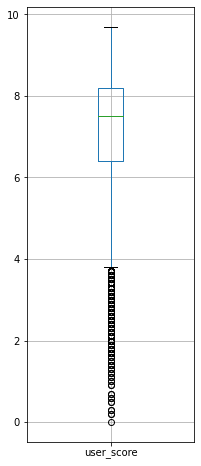

In [32]:
q1 = data['user_score'].quantile(0.25)  # Первый квартиль (квантиль = 0,25)
q3 = data['user_score'].quantile(0.75)  # Третий квартиль (квантиль = 0,75)

print(f'Предполагаемые выбросы за пределами: до {q1 - 1.5 * (q3 - q1):.2f} и свыше {q3 + 1.5 * (q3 - q1):.2f}')
print(data['user_score'].describe())

data.boxplot('user_score', figsize=(3, 8))

Получается, нам надо удалить все низкие оценки, так как t-тесты чувствительны к выбросам, то есть хорошо работают при примерно равных среднем и медиане. Но удаление низких оценок (до 3,7) - это искажение общей картины (не могут же игры иметь только положительные оценки). Значит, наоборот, имеем значительное количество завышенных оценок, сказывающихся на медиане. Но они все входят в предел q3+1,5iqr. Поэтому оставим данные как есть. Средняя оценка, с которой работает t-тест, в данном случае точнее, чем медианная.

###  Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковы (средние двух выборок равны между собой); альтернативная: средний пользовательский рейтинг платформы Xbox One отличается от рейтинга платформы PC.
Зададим пороговое значение уровня статистической значимости alpha = 0,05 (ошибка в 5 случаев из 100).

In [33]:
alpha = 0.05 #  Задали критический уровень статистической значимости

results = (st.ttest_ind(
    data_new[data_new['platform'] == 'XOne']['user_score'],   # data_new теперь содержит данные только актуального периода
    data_new[data_new['platform'] == 'PC']['user_score'])
          ) 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу даже при пороге 0,05 отвергнуть не удалось, так что, вероятнее всего, средние пользовательские рейтинги XOne и PC примерно равны между собой. 

###  Средние пользовательские рейтинги жанров Action и Sports разные.

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports одинаковы (средние двух выборок равны между собой); альтернативная: средний пользовательский рейтинг жанра Action отличается от рейтинга жанра Sports.
Зададим пороговое значение уровня статистической значимости alpha = 0,01.

In [34]:
alpha = 0.01 #  Задали критический уровень статистической значимости

results = (st.ttest_ind(
    data_new[data_new['genre'] == 'Action']['user_score'], 
    data_new[data_new['genre'] == 'Sports']['user_score'])
          ) 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


Значит, скорее всего, верна альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports отличаются.

## Общий вывод 
Попробуем выявить определяющие успешность игры закономерности.
Данные по JP, как выяснилось, очень специфичны и подходят для прогнозов только в этой стране. Учитывая, что уровень продаж в Японии составляет только около 1/8 от остальных проанализированных, составим прогноз, опирающийся на данные по Европе и Сев. Америке. Такой прогноз будет справедлив и в целом, так как их суммарная доля на рынке подавляющая, а предпочтения схожи.

Итак, успешная в актуальном периоде игра - это игра жанра Action или Shooter или, возможно, Sports или Role-Playing на платформе PS4, PS3 или X360.

Для регионов по отдельности попробуем спрогнозировать "успешность" игры:
- Америка: жанр Action или Shooter, платформа Х360, PS4 или PS3, категория "М" рейтинга ESRB. 
- Европа:   жанр Action или Shooter, платформа PS4, PS3 или Х360, категория "М" рейтинга ESRB.
- Япония:  жанр Role-Playing или Action, платформа 3DS, возможно, PS3, игра без рейтинга ESRB (собственного производства).